In [1]:
import torch
import torch.nn.functional as F

In [2]:
with open('./names.txt','r',encoding='utf-8') as f:
    words = f.read().splitlines()

In [3]:
len(words)

32033

In [73]:
chars = []
chars.append('.')
chars = chars+sorted(list(set(''.join(words))))
vocab_size = len(chars)

In [5]:
# 定义两个函数用以转换字符到数字和数字到字符
stoi = lambda x: chars.index(x)
itos = lambda x: chars[x]

In [6]:
block_size = 3
X,Y = [],[]
for w in words[:]:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi(ch)
        X.append(context)
        Y.append(ix)
        # print(''.join(itos(xi) for xi in context), '--->', itos(ix))
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [12]:
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi(ch)
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [107]:
n_embed = 10
input_neurons = n_embed * block_size
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),generator=g)
# 这里将激活前的参数层进行缩小，使得整个层的原始输出值在tanh计算的时候是落在tanh梯度较大的位置，这样使得初始学习的时候所有的神经元都可以直接参与计算
w1 = torch.randn((input_neurons,n_hidden),generator=g) * 0.2
b1 = torch.randn(n_hidden,generator=g) * 0.01
# 将最后一层的权重缩小，这样可以将第一次的logits，即原始输出值缩小，这样所有的值都相当于平均在0附近，取样的概率相等，初始值loss可控
w2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size,generator=g) * 0
parameters = [C,w1,b1,w2,b2]
for p in parameters:
    p.requires_grad = True

In [93]:
sum(n.nelement() for n in parameters)

11897

In [94]:
epoch = 2000
batch_size = 32
learning_rate = 0.1

In [108]:
for _ in range(epoch):
    # build mini batch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    hpreact = emb.view(emb.shape[0],input_neurons) @ w1 +b1
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,Ytr[ix])
    print(f'loss = {loss}')
    break
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -learning_rate * p.grad
# print(f'loss = {loss}')


loss = 3.314589500427246


h_show shape is torch.Size([6400])


(array([  1.,   1.,   1.,   3.,   2.,   8.,  12.,  19.,  20.,  13.,  28.,
         45.,  57.,  76., 122., 129., 166., 215., 234., 266., 289., 329.,
        363., 371., 438., 426., 392., 331., 354., 316., 282., 231., 195.,
        153., 136., 114.,  66.,  49.,  41.,  29.,  20.,  15.,   8.,  12.,
          4.,   6.,   4.,   6.,   0.,   2.]),
 array([-0.19570257, -0.18768334, -0.17966411, -0.17164488, -0.16362566,
        -0.15560643, -0.1475872 , -0.13956797, -0.13154875, -0.12352952,
        -0.11551029, -0.10749106, -0.09947184, -0.09145261, -0.08343338,
        -0.07541415, -0.06739492, -0.0593757 , -0.05135647, -0.04333724,
        -0.03531801, -0.02729879, -0.01927956, -0.01126033, -0.0032411 ,
         0.00477812,  0.01279735,  0.02081658,  0.02883581,  0.03685504,
         0.04487426,  0.05289349,  0.06091272,  0.06893195,  0.07695117,
         0.0849704 ,  0.09298963,  0.10100886,  0.10902808,  0.11704731,
         0.12506654,  0.13308577,  0.141105  ,  0.14912422,  0.15714345,
 

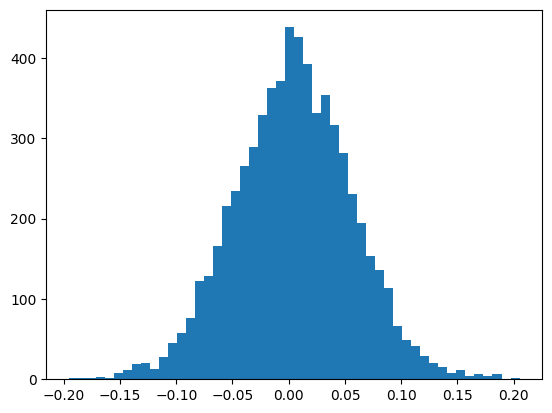

In [101]:
import matplotlib.pyplot as plt

h_show = h.view(-1)
print(f'h_show shape is {h_show.shape}')

plt.hist(h_show.tolist(),50)

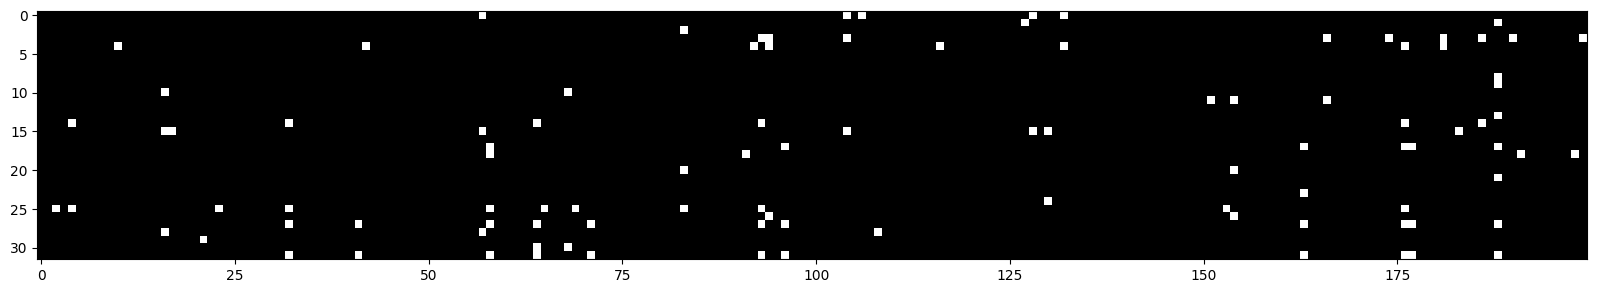

In [109]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

(array([  1.,   1.,   1.,   7.,   2.,   5.,  18.,  12.,  13.,  22.,  29.,
         55.,  85.,  77., 139., 169., 193., 252., 262., 334., 309., 371.,
        374., 414., 435., 394., 394., 373., 311., 250., 245., 172., 156.,
        138., 112.,  75.,  44.,  53.,  29.,  21.,  15.,  15.,  12.,   3.,
          4.,   2.,   0.,   1.,   0.,   1.]),
 array([-0.2043062 , -0.19567678, -0.18704737, -0.17841795, -0.16978854,
        -0.16115912, -0.15252971, -0.14390029, -0.13527088, -0.12664146,
        -0.11801205, -0.10938263, -0.10075322, -0.0921238 , -0.08349439,
        -0.07486497, -0.06623555, -0.05760614, -0.04897672, -0.04034731,
        -0.03171789, -0.02308848, -0.01445906, -0.00582965,  0.00279977,
         0.01142918,  0.0200586 ,  0.02868801,  0.03731743,  0.04594684,
         0.05457626,  0.06320568,  0.07183509,  0.08046451,  0.08909392,
         0.09772334,  0.10635275,  0.11498217,  0.12361158,  0.132241  ,
         0.14087041,  0.14949983,  0.15812924,  0.16675866,  0.17538807,
 

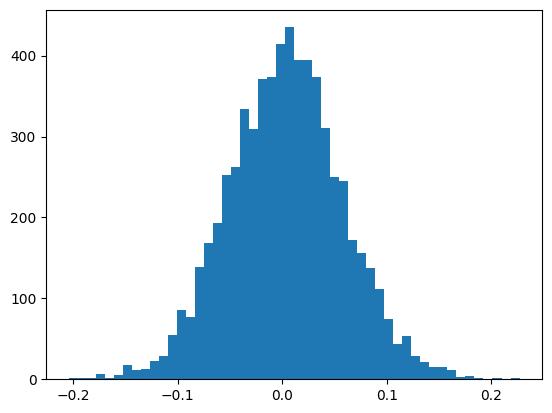

In [106]:
plt.hist(hpreact.view(-1).tolist(),bins=50)

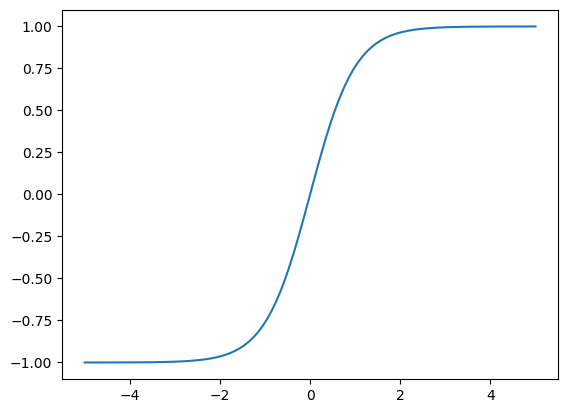

In [47]:
import matplotlib.pyplot as plt

xi = torch.linspace(-5,5,100)
yi = torch.tanh(xi)
plt.plot(xi,yi)

In [129]:
# 评估所有数据集的loss
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0],input_neurons) @ w1 +b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits,Ydev)
print(f'loss = {loss}')

loss = 2.530228614807129


In [214]:
# generate sample
for i in range(10):
    str = ''
    start_chs = '...'
    while True:      
        x_start = C[torch.tensor([stoi(i) for i in start_chs])].view(1,-1).float()
        h1 = torch.tanh(x_start @ w1 +b1)
        h2 =  torch.tanh(h1 @ w2 + b2)
        logits = h2 @ w3 + b3
        prob = torch.exp(logits)/torch.sum(torch.exp(logits))
        ix = torch.multinomial(prob,num_samples=1,replacement=True)
        if ix == 0:
            print(str)
            break
        else:
            start_chs = start_chs[1:] + itos(ix)
        str += itos(ix)

make
jahina
theise
xanlyxctori
waewahana
liena
lisa
jennon
cylee
emerine
